In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, last_tune_log, tune, Verbosity
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "020"
run = wandb.init(
    project="grpo-tests",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "nyt-connections"},
)

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
random.seed(42)
random.shuffle(train_tasks)
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(436, 72, 92, 436)

In [5]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0

expected_tokens = 4000  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 5e-6
model = models.qwen_14b()
wandb.config["model"] = model_name = model.base_model
num_iterations = 10
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 64
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 8
wandb.config["tasks_per_iter"] = tasks_per_iter = 8
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
vllm = await start_vllm(
    model_name,
    max_concurrent_requests=1024,
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=1024,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=180 + 15 * torch.cuda.device_count(),
    verbosity=verbosity,
)

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-14B --block-size=32 --disable-log-requests --enable-prefix-caching --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=2 --port=8001 --api-key=default
INFO 02-19 23:57:47 __init__.py:190] Automatically detected platform cuda.
INFO 02-19 23:57:48 api_server.py:840] vLLM API server version 0.7.2
INFO 02-19 23:57:48 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-14B', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.12s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.41it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.16it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.01it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.06it/s]



(VllmWorkerProcess pid=66997) INFO 02-19 23:58:07 model_runner.py:1115] Loading model weights took 13.9476 GB
INFO 02-19 23:58:07 model_runner.py:1115] Loading model weights took 13.9476 GB
(VllmWorkerProcess pid=66997) INFO 02-19 23:58:09 worker.py:267] Memory profiling takes 2.06 seconds
(VllmWorkerProcess pid=66997) INFO 02-19 23:58:09 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
(VllmWorkerProcess pid=66997) INFO 02-19 23:58:09 worker.py:267] model weights take 13.95GiB; non_torch_memory takes 1.57GiB; PyTorch activation peak memory takes 1.45GiB; the rest of the memory reserved for KV Cache is 58.18GiB.
INFO 02-19 23:58:09 worker.py:267] Memory profiling takes 2.15 seconds
INFO 02-19 23:58:09 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-19 23:58:09 worker.py:267] model weights take 13.95GiB; non_torch_memory takes 1.82GiB; Py

Capturing CUDA graph shapes: 100%|██████████| 131/131 [00:51<00:00,  2.57it/s]


INFO 02-19 23:59:43 custom_all_reduce.py:226] Registering 10185 cuda graph addresses
(VllmWorkerProcess pid=66997) INFO 02-19 23:59:43 model_runner.py:1562] Graph capturing finished in 51 secs, took 1.39 GiB
INFO 02-19 23:59:44 model_runner.py:1562] Graph capturing finished in 51 secs, took 1.39 GiB
INFO 02-19 23:59:44 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 96.70 seconds
INFO 02-19 23:59:44 api_server.py:756] Using supplied chat template:
INFO 02-19 23:59:44 api_server.py:756] None
INFO 02-19 23:59:44 launcher.py:21] Available routes are:
INFO 02-19 23:59:44 launcher.py:29] Route: /openapi.json, Methods: HEAD, GET
INFO 02-19 23:59:44 launcher.py:29] Route: /docs, Methods: HEAD, GET
INFO 02-19 23:59:44 launcher.py:29] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 02-19 23:59:44 launcher.py:29] Route: /redoc, Methods: HEAD, GET
INFO 02-19 23:59:44 launcher.py:29] Route: /health, Methods: GET
INFO 02-19 23:59:44 launcher.py:29] Route: /ping, M

INFO:     Started server process [66646]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-19 23:59:51 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-19 23:59:51 metrics.py:455] Avg prompt throughput: 0.8 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-19 23:59:51 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:46490 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x7007a79a2520>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


In [33]:
i = 1
semaphore = asyncio.Semaphore(int(4 * vllm.max_concurrent_tokens / expected_tokens))
offset = (i - 1) * stride
(_, val_stats), (train_results, train_stats) = await asyncio.gather(
    get_task_results(
        tasks=val_tasks,
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        pbar_desc="val",
        semaphore=semaphore,
    ),
    get_task_results(
        tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=False,
        n=samples_per_task,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        pbar_desc="train",
        semaphore=semaphore,
        transform=TaskResultTokenizer(tokenizer),
    ),
)

val:   0%|          | 0/72 [00:00<?, ?it/s]

train:   0%|          | 0/512 [00:00<?, ?it/s]

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1903' coro=<get_chat_completion() done, defined at /home/ubuntu/sky_workdir/experiments/lib/chat_completions.py:59> exception=APIConnectionError('Connection error.')>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/.venv/lib/python3.12/site-packages/httpx/_transports/default.py", line 101, in map_httpcore_exceptions
    yield
  File "/home/ubuntu/sky_workdir/.venv/lib/python3.12/site-packages/httpx/_transports/default.py", line 394, in handle_async_request
    resp = await self._pool.handle_async_request(req)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/sky_workdir/.venv/lib/python3.12/site-packages/httpcore/_async/connection_pool.py", line 256, in handle_async_request
    raise exc from None
  File "/home/ubuntu/sky_workdir/.venv/lib/python3.12/site-packages/httpcore/_async/connection_pool.py", line 236, in handle_async_request
    response = await conne

CancelledError: 

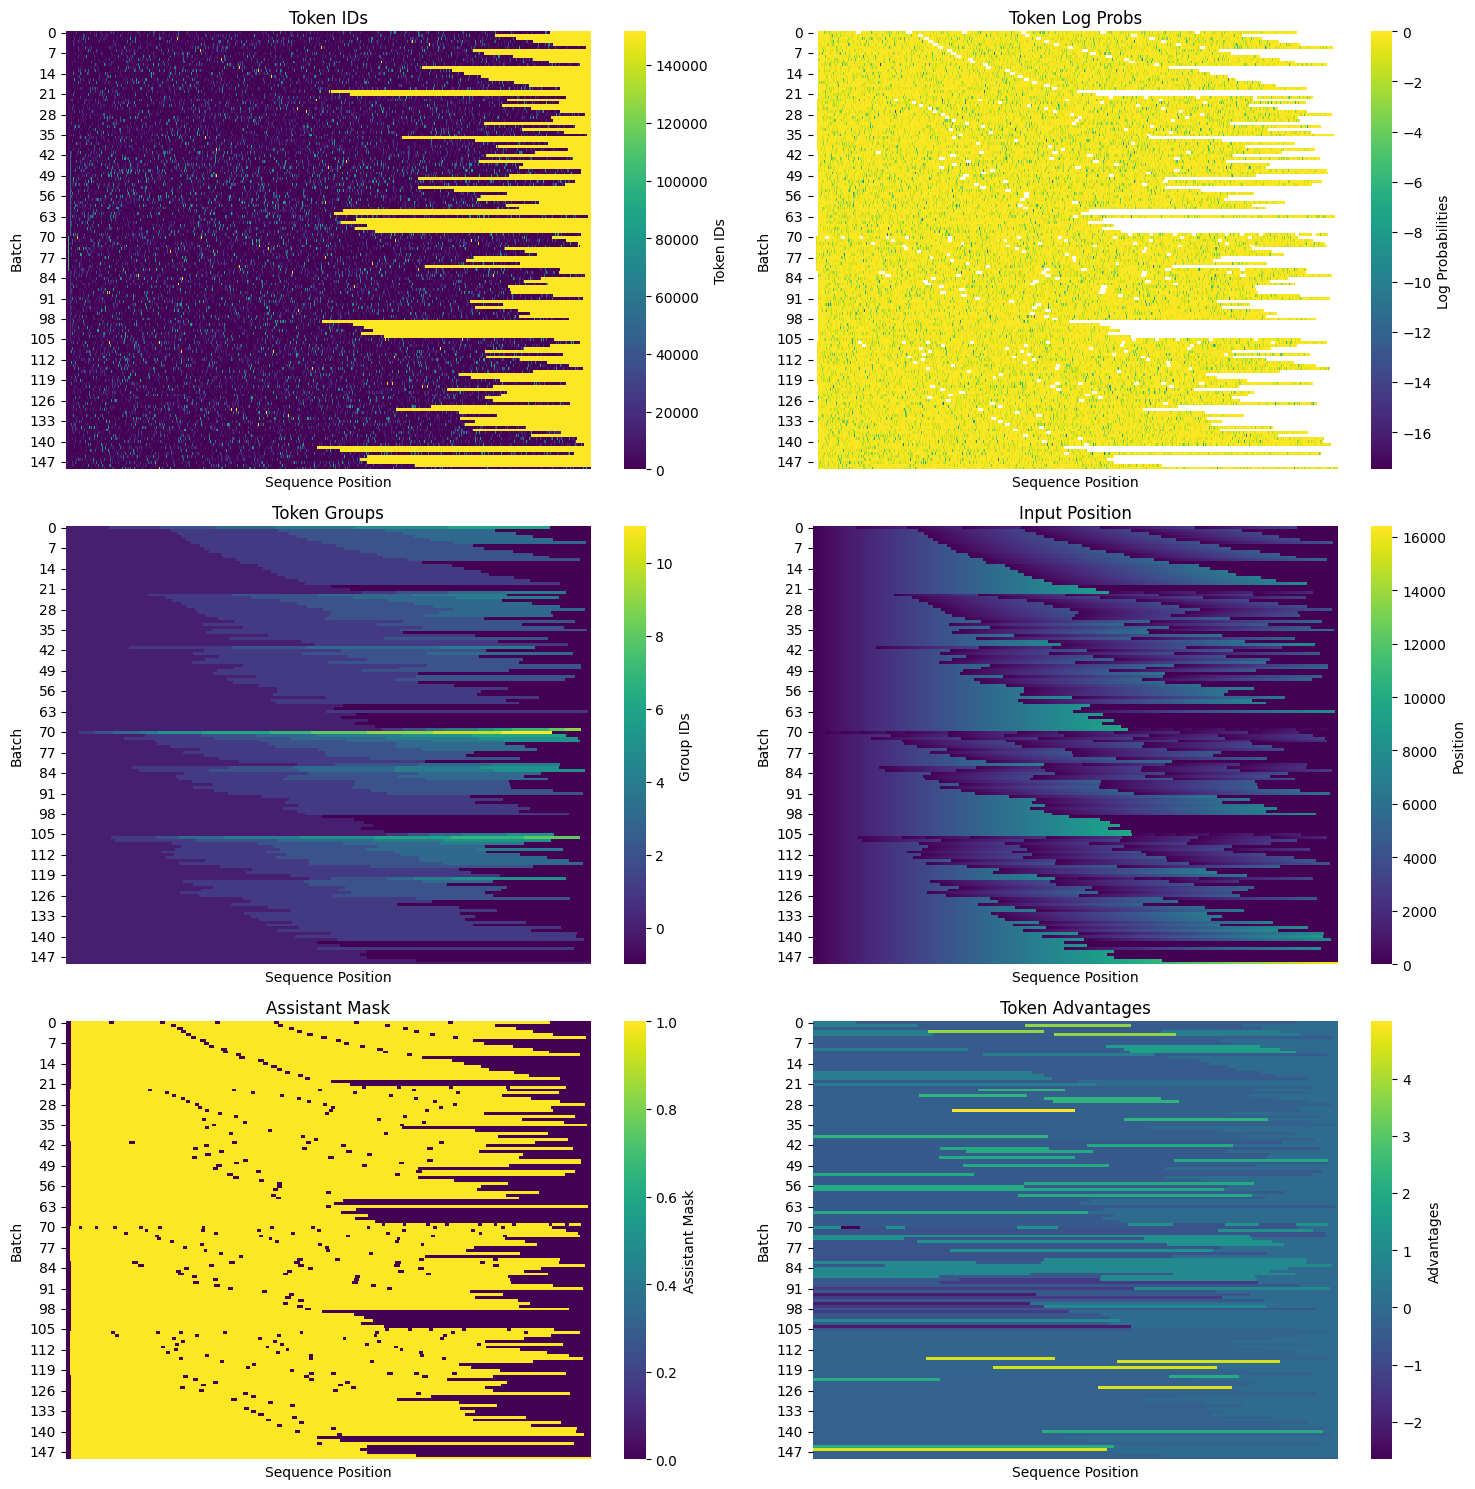

In [8]:
packed_tensors = packed_tensors_from_tokenized_results(
    [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ],
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
if verbosity == 2:
    plot_packed_tensors(packed_tensors)
else:
    print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")

In [17]:
model.tune_optimizer = "torch.optim.AdamW"

In [27]:
optimizer_config = ComponentConfig(model.tune_optimizer, lr=lr)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True
model_name = await tune(
    base_model=model.base_model,
    output_dir=output_dir,
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        loss=ComponentConfig(
            GRPO,
            clip_epsilon=clip_epsilon,
            entropy_coef=entropy_coef,
            kl_coef=kl_coef,
            tanh=True,
        ),
        shuffle=True,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=2,
        compile=True,
    ),
    verbosity=verbosity,
)

$ tune run --nproc-per-node=2 lib.recipe.TuneRecipe --config ./models/020/config.yaml
Running with torchrun...


W0219 23:28:12.111000 54117 torch/distributed/run.py:793] 
W0219 23:28:12.111000 54117 torch/distributed/run.py:793] *****************************************
W0219 23:28:12.111000 54117 torch/distributed/run.py:793] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0219 23:28:12.111000 54117 torch/distributed/run.py:793] *****************************************
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-14B/snapshots/5ee96d8a09692

Writing logs to models/020/logs/log_1740007696.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Compiling model layers with torch.compile...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.17 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 8.18 GiB
	GPU peak memory reserved: 8.40 GiB
	GPU peak memory active: 8.18 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Compiling loss with torch.compile...
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|19|Loss: -0.0022:  51%|█████▏    | 19/37 [09:20<08:27, 28.21s/it, entropy=0.623, kl_div=nan, loss=-0.00219, policy=-0.00219]  

AssertionError: No model checkpoint files found to save in output directory ./models/020